# AutoGenU for Jupyter

An Automatic C++ Code Generator for Nonlinear Model Predictive Control (NMPC)  

---  

## Formulation of the optimal control problem: Cart pole

### Model description
<img src="https://raw.github.com/wiki/mayataka/CGMRES/images/fig_cartpole.png" width=40%>

The above figure shows the model of a cart pole. By the Lagrange's method, the equation of the motion is derived as  
$$\ddot{y} = \frac{1}{m_c + m_p \sin ^2{\theta}} \left\{ u + m_p \sin{\theta} (l \dot{\theta}^2 + g \cos{\theta}) \right\}, $$  
$$\ddot{\theta} = \frac{1}{l(m_c + m_p \sin ^2{\theta})} \left\{ - u \cos{\theta} - m_p l {\dot{\theta}}^2 \cos{\theta} \sin{\theta} - (m_c + m_p) g \sin{\theta} \right\} .$$
We also assume that the input of the cartpole is limited as  
$$u_{\rm min} \leq u \leq u_{\rm max} , $$
where $u_{\rm min}, u_{\rm max} \in \mathbb{R}$.

### Formulation of the optimal control problem
We define the state vector as
$$ x = \begin{bmatrix} y \\ \theta \\ \dot{y} \\ \dot{\theta} \end{bmatrix} .$$
The state equation is then given as 
$$\dot{x} = f(t, x, u) = \begin{bmatrix} \dot{y} \\ \dot{\theta} \\ \frac{1}{m_c + m_p \sin ^2{\theta}} \left\{ u + m_p \sin{\theta} (l \dot{\theta}^2 + g \cos{\theta}) \right\} \\ \frac{1}{l(m_c + m_p \sin ^2{\theta})} \left\{ - u \cos{\theta} - m_p l {\dot{\theta}}^2 \cos{\theta} \sin{\theta} - (m_c + m_p) g \sin{\theta} \right\} \end{bmatrix} .$$
To apply NMPC based on the C/GMRES method, we transform the inequality constraints into equality constraints by introducing a virtual control input $u_{\rm dummy} \in \mathbb{R}$. The transformed equality constraint is then given by
$$C(t, x, u) = u^2 + u_{\rm dummy}^2 - (\frac{u_{\rm max} - u_{\rm min}}{2})^2 = 0, $$
where $u_{\rm dummy} \in \mathbb{R}$.  
Next, we set the cost function 
$$ J = \varphi(t, x) + \int_{t}^{t+T} L(t, x, u) .$$
The objective is to invert the pole and stabilize the cart around $y=0$. In other words, we want to converge the state of the cart pole to 
$$x_{\rm ref} := \begin{bmatrix} 0 \\ \pi \\ 0 \\ 0 \end{bmatrix}.$$  
To achieve this goal, we set the terminal cost as
$$\varphi(t,x) = \frac{1}{2} (x - x_{\rm ref})^{\rm T} Q_{\rm terminal} (x - x_{\rm ref}) ,$$  
where $Q_{\rm terminal} = {\rm diag}\left\{ {q_{\rm terminal}}_1, {q_{\rm terminal}}_2, {q_{\rm terminal}}_3, {q_{\rm terminal}}_4 \right\}$ and ${q_{\rm terminal}}_1, {q_{\rm terminal}}_2, {q_{\rm terminal}}_3, {q_{\rm terminal}}_4$ are positive real constants. We also set the stage cost as  
$$L(t, x, u) = \frac{1}{2} (x - x_{\rm ref})^{\rm T} Q (x - x_{\rm ref}) + \frac{1}{2} r u^2 - r_{\rm dummy} u_{\rm dummy},$$  
where $Q = {\rm diag} \left\{ q_1, q_2, q_3, q_4 \right\}$ with positive real constants $q_1, q_2, q_3, q_4$, $r$ is positive real constant, and $r_{\rm dummy}$ is so, too. Note that the term $- r_{\rm dummy} u_{\rm dummy}$ is to determine the sign of $u_{\rm dummy}$ uniquely.

### Numerical solver of NMPC
In the following example, we compute the solution of NMPC using the original C/GMRES method (single shooting).

---

# Generate C++ codes of NMPC model  

## Import module

In [1]:
from autogenu import autogenu

## Set dimensions and define `AutoGenU`
- `dimx`: Dimension of the state vector $x$   
- `dimu`: Dimension of the control input vector $u$  
- `model_name`: Name of the model. Used as the name of the directory containing the generated C++ source files.

In [2]:
dimx = 4
dimu = 1
model_name = 'cartpole'
ag = autogenu.AutoGenU(model_name, dimx, dimu)

## Generate t, x, and u, necessary variables to formulate of the optimal control problem
- `t`: Time parameter $t$  
- `x`: The state vector $x$  
- `u`: The control input vector $u$  

In [3]:
t = ag.define_t()
x = ag.define_x()
u = ag.define_u()

## Define variables used in the state equation, constraints, and cost function
- Define a scalar variable whose name is "var" as  
`var = ag.define_scalar_var('var') `

- Define scalar variables whose names are "var\_1", "var\_2", ..., "var\_n" as  
`var_1, var_2, ..., var_n = ag.define_scalar_vars('var_1', 'var_2', ..., 'var_n')`

- Define array variables whose name is "vec" and dimension is dim_vec as  
`vec = ag.define_array_var('vec', dim_vec)`

In [4]:
# Variables used in the state function
m_c, m_p, l, g = ag.define_scalar_vars('m_c', 'm_p', 'l', 'g')

# Variables used in the constraints on the control input
u_min, u_max, u_eps = ag.define_scalar_vars('u_min', 'u_max', 'u_eps')

# Variables used in the cost function
q = ag.define_array_var('q', dimx)
q_terminal = ag.define_array_var('q_terminal', dimx)
x_ref = ag.define_array_var('x_ref', dimx)
r = ag.define_array_var('r', dimu)

## Define the state equation, constraints, the stage cost, and the terminal cost
- `f`: The state equation $ f(t, x, u)$  
- `C`: The equality constraisnts $C(t, x, u) = 0 $  
- `h`: The inequality constraisnts $h(t, x, u) \leq 0$ considered by semi-smooth Fischer-Burumeister method  
- `L`: The stage cost $L(t, x, u)$  
- `phi`: The terminal cost $\phi (t, x)$  

Note: array indices start with 0

In [5]:
# Import symbolic math from sympy. If you need more functions, import same as below.
from sympy import sin, cos, tan, exp, log, ln, sinh, cosh, tanh, diff, sqrt

In [6]:
# Define the state equation
f = [x[2], 
     x[3],
    (u[0] + m_p*sin(x[1])*(l*x[1]*x[1] + g*cos(x[1])) )/( m_c+m_p*sin(x[1])*sin(x[1])),
    (-u[0] * cos(x[1]) - m_p*l*x[1]*x[1]*cos(x[1])*sin(x[1]) - (m_c+m_p)*g*sin(x[1]) )/( l*(m_c + m_p*sin(x[1])*sin(x[1])))]

# Define the constraints
#C = [u[0]**2 + u[1]**2 - ((u_max-u_min)**2)/4]

# Define the inequality constraints considered using the semi-smooth Fischer-Burmeister method
#h = []

# Define barrier function
u_barrier = sum(-ln(u[i]-u_min) - ln(u_max-u[i]) for i in range(dimu))

# Define the stage cost
L = sum(q[i]*(x[i] - x_ref[i])**2 for i in range(dimx))/2 + (r[0] * u[0]**2)/2 + u_barrier

# Define the terminal cost
phi = sum(q_terminal[i]*(x[i] - x_ref[i])**2 for i in range(dimx))/2 

In [7]:
# Set functions
ag.set_functions(f, L, phi)

## Set Parameters
Set values for all parameters you defined.
- Set `value` for a scalar variable whose name is "var" as  
`ag.set_scalar_var('var', value) `

- Set `value_1`, `value_2`, ..., `value_n`, for scalar variables whose names are "var\_1", "var\_2", ..., "var\_n" as  
`ag.set_scalar_vars(['var_1', value_1], ['var_2', value_2], ..., ['var_n', value_n])`

- Set array variables `var_1`, `var_2`, ..., `var_n` whose name is "vec" and dimension is n as  
`ag.define_array_var('vec', [var_1, var_2, ..., var_n])`

In [8]:
ag.set_scalar_vars(['m_c', 2], ['m_p', 0.2], ['l', 0.5], ['g', 9.80665], 
                   ['u_min', -15], ['u_max', 15], ['u_eps', 0.001])
ag.set_array_var('q', [2.5, 10, 0.01, 0.01])
ag.set_array_var('r', [1])
ag.set_array_var('q_terminal', [2.5, 10, 0.01, 0.01])
ag.set_array_var('x_ref', [0, 'M_PI', 0, 0])

## Generate C++ codes of NMPC model
Generate `nmpc_model.hpp` and `nmpc_model.cpp`, C++ source files of NMPC problem settings.  
- `use_simplification`: The flag for simplification. If `True`, symbolic functions are simplified. However, if functions are too complicated, it takes too much time. Default is `False`.  
- `use_case`: The flag for common subexpression elimination. If `True`, common subexpressions in fxu, phix, hx, and hu are eliminated when `nmpc_model.cpp` is generated. Default is `False`. 

In [9]:
use_simplification = False
use_cse = True

ag.generate_source_files(use_simplification, use_cse)

---  
# Generate C++ codes for numerical simulation  

## Set parameters for the C/GMRES method

- `T_f`, `alpha`: Parameters for the length of the horizon $T(t)$: $T(t) = T_f (1 - e^{-\alpha t})$. The length of the horizon converges to `T_f` and the speed of the convergence is determied by `alpha`. 
- `N`: The division number of the horzion for the numerical computation.  
- `finite_difference_increment`: Step length of a finite difference approximations of hessian-vector products in C/GMRES.   
- `zeta`: A stabilization parameter of the C/GMRES method. Basically, must be set by the reciprocal of the sampling time.  
- `kmax`: The maximam number of the iteration of the GMRES.

In [10]:
T_f = 2.0
alpha = 1.0
N = 100

ag.set_solver_parameters(T_f, alpha, N)

## Set parameters for the initialization of the solution  
- `solution_initial_guess`: The initial guess of the solution of the optimal control problem (OCP) for initialization of the solution of NMPC.  

In [11]:
solution_initial_guess = [0]

ag.set_solution_initial_guess(solution_initial_guess)

## Set parameters for numerical simulation
- `initial_time`: Initial time of the numerical simulation.  
- `initial_state`: Initial state vector of the system.  
- `simulation_time`: Simulation time of the numerical simulation.  
- `sampling_time`: The sampling time of the numerical simulation.

In [12]:
initial_time = 0  
initial_state = [0, 0, 0, 0]  
simulation_time = 10
sampling_time = 0.001  

ag.set_simulation_parameters(initial_time, initial_state, simulation_time, sampling_time)

## Generate main.cpp and CMakeLists.txt

In [13]:
ag.generate_main()
ag.generate_cmake()

## Build and run simulation

- `generator`: An optional variable for Windows user to choose the generator of CMake. If 'MSYS', then 'MSYS Makefiles' is used. If 'MinGW', then 'MinGW Makefiles' is used. The default value is 'Auto' and the generator is selected automatically. If sh.exe exists in your PATH, MSYS is choosed, and otherwise MinGW is used. 
- `remove_build_dir`: If `True`, the existing build directory is removed. If `False`, the build directory is not removed. Need to be set `True` if you change the generator. Default is `False`.

In [19]:
generator = 'Auto'  
remove_build_dir = False
ag.build(generator, remove_build_dir)
ag.run_simulation()

-- Configuring done
-- Generating done
-- Build files have been written to: /home/sotaro/src/continuation-DDP/models/cartpole/build


[ 28%] Built target memory_manager
[ 57%] Built target ocp_model
[100%] Built target a.out


Start simulation
End simulation
Total CPU time for control update: 0.354481 [sec]
sampling time: 0.001 [sec]
CPU time for per control update: 3.54481e-05 [sec]


## Plot the simulation results

In [15]:
import autogenu.simulation_plottor as simplot

The graph of the simlation results is generated at models/cartpole/build/simulation_result/cartpole.pdf



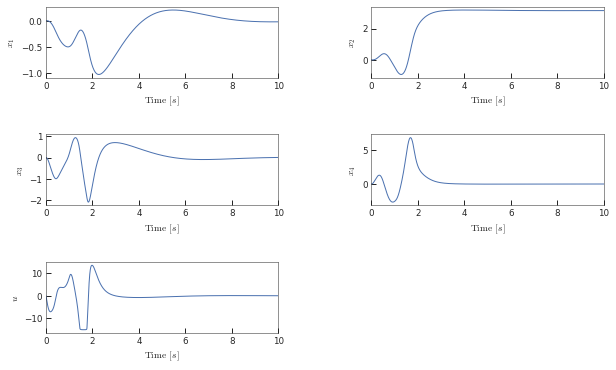

In [16]:
plottor = simplot.SimulationPlottor(model_name)
plottor.set_scales(2,5,2)
#plottor.show_plots()
plottor.save_plots()

## Draw animations of the simulation results

In [17]:
import autogenu.animation_generator as animgen

The animation of the simlation results is generated at models/cartpole/build/simulation_result/cartpole.mp4



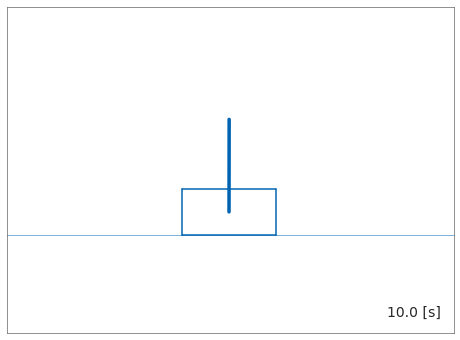

In [18]:
anim = animgen.CartPole(model_name)
anim.set_skip_frames(10)
anim.generate_animation()